<a href="https://colab.research.google.com/github/rerebebeccacca/20210624-deep-learning-class/blob/main/06_Magnetic_defect_binary_tf_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Defect Class

*   MT_Blowhole
*   MT_Break
*   MT_Crack
*   MT_Fray
*   MT_Uneven
*   MT_Free



In [ ]:
# download dataset from https://drive.google.com/file/d/12iinuMZkaZOZGXlkPsUnmETaE-cMlyHu/view?usp=sharing
!gdown --id 12iinuMZkaZOZGXlkPsUnmETaE-cMlyHu --output defect.zip

Downloading...
From: https://drive.google.com/uc?id=12iinuMZkaZOZGXlkPsUnmETaE-cMlyHu
To: /content/defect.zip
53.2MB [00:00, 202MB/s]


In [ ]:
!unzip -q defect.zip

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
from tqdm.auto import tqdm
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split

In [ ]:
IMG_SIZE = 256
class_map = {'MT_Free':0, 'MT_Blowhole': 1}

In [ ]:
# Read single image
img_paths = glob('./Magnetic-tile-defect/MT_Blowhole/Imgs/*.jpg') + glob('./Magnetic-tile-defect/MT_Free/Imgs/*.jpg')

In [ ]:
# number of images
len(img_paths)

1067

./Magnetic-tile-defect/MT_Free/Imgs/exp2_num_178482.jpg 
 (322, 190, 3)


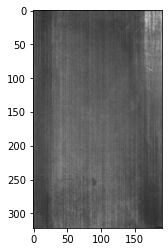

In [ ]:
# show image
img_idx = np.random.randint(0, len(img_paths))
path = img_paths[img_idx]
img = cv2.imread(path)
print(path, '\n', img.shape)
plt.imshow(img)
plt.show()

((322, 190, 3), (256, 256, 3))

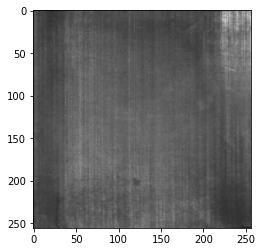

In [ ]:
# Resize img
img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
plt.imshow(img_resized)
img.shape, img_resized.shape

In [ ]:
# Extract img class
img_path = img_paths[img_idx]
img_path

'./Magnetic-tile-defect/MT_Free/Imgs/exp2_num_178482.jpg'

In [ ]:
cls = img_path.split('/')[-3]
cls

'MT_Free'

In [ ]:
class_map[cls]

0

### Read all images

In [ ]:
data_count = len(img_paths)
X = np.zeros((data_count, IMG_SIZE, IMG_SIZE, 3))
y = np.zeros((data_count, ))

In [ ]:
for i, path in tqdm(enumerate(img_paths)):
    # read and preprocess image
    img = cv2.imread(path)
    img_resize = cv2.resize(img, (IMG_SIZE, IMG_SIZE)) # resize
    img_resize = img_resize / 255. # normalization
    # get image's label
    cls = path.split('/')[-3]
    
    X[i] = img_resize
    y[i] = class_map[cls]

In [ ]:
# label count
unique_classes, counts = np.unique(y, return_counts=True)
unique_classes, counts

(array([0., 1.]), array([952, 115]))

In [ ]:
# split train and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5566)

# one-hot encoding 
y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=2)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((853, 256, 256, 3), (214, 256, 256, 3), (853, 2), (214, 2))

In [ ]:
y_train

In [ ]:
unique_classes, counts = np.unique(y_train, return_counts=True)
unique_classes, counts

(array([0., 1.]), array([763,  90]))

In [ ]:
763 / 853

0.8944900351699883

In [ ]:
X_train[0]

### Build model

In [ ]:
def build_model():
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = layers.Conv2D(filters=16, kernel_size=3, activation='relu')(inputs)
    x = layers.Conv2D(filters=16, kernel_size=3, activation='relu')(x)
    x = layers.MaxPool2D(2)(x)
    x = layers.Conv2D(filters=32, kernel_size=3, activation='relu')(x)
    x = layers.Conv2D(filters=32, kernel_size=3, activation='relu')(x)
    x = layers.MaxPool2D(2)(x)
    x = layers.Conv2D(filters=64, kernel_size=3, activation='relu')(x)
    x = layers.Conv2D(filters=64, kernel_size=3, activation='relu')(x)
    x = layers.MaxPool2D(2)(x)
    x = layers.Conv2D(filters=128, kernel_size=3, activation='relu')(x)
    x = layers.Conv2D(filters=128, kernel_size=3, activation='relu')(x)
    x = layers.MaxPool2D(2)(x)
    x = layers.Conv2D(filters=256, kernel_size=3, activation='relu')(x)
    x = layers.Conv2D(filters=256, kernel_size=3, activation='relu')(x)
    x = layers.MaxPool2D(2)(x)
    # x = layers.Flatten()(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(64, activation='relu')(x)
    prediction = layers.Dense(1, activation='sigmoid')(x)
    model = models.Model(inputs=inputs, outputs=prediction)
    return model

def resnet():
    base_model = tf.keras.applications.ResNet50(include_top=False, 
                                                weights=None, 
                                                input_shape=(IMG_SIZE, IMG_SIZE, 3))
    x = layers.GlobalAveragePooling2D()(base_model.output)

    #x = layers.Dense(1, activation='sigmoid')(x)
    #
    x = layers.Dense(2, activation='softmax')(x)

    model = models.Model(inputs=base_model.input, outputs=x)
    return model


In [ ]:
model = resnet() # build_model()
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
model.compile(#loss=tf.keras.losses.binary_crossentropy,
              loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
            #   metrics=[tf.keras.metrics.BinaryAccuracy(name="binary_acc", threshold=0.5)],
              metrics=['accuracy']
              )

In [ ]:
logs = model.fit(X_train, y_train,
                 batch_size=32,
                 epochs=50,
                 verbose=1,
                 validation_data=(X_test, y_test))

Epoch 1/50
27/27 [==============================] - 53s 489ms/step - loss: 1.0226 - accuracy: 0.8312 - val_loss: 0.5873 - val_accuracy: 0.8832
Epoch 2/50
27/27 [==============================] - 12s 463ms/step - loss: 0.3557 - accuracy: 0.8828 - val_loss: 0.5496 - val_accuracy: 0.8832
Epoch 3/50
27/27 [==============================] - 12s 448ms/step - loss: 0.3463 - accuracy: 0.8875 - val_loss: 0.3794 - val_accuracy: 0.8832
Epoch 4/50
27/27 [==============================] - 12s 441ms/step - loss: 0.3291 - accuracy: 0.8910 - val_loss: 0.4454 - val_accuracy: 0.8832
Epoch 5/50
27/27 [==============================] - 12s 436ms/step - loss: 0.3399 - accuracy: 0.8863 - val_loss: 0.4458 - val_accuracy: 0.8832
Epoch 6/50
27/27 [==============================] - 12s 435ms/step - loss: 0.3155 - accuracy: 0.8863 - val_loss: 0.3808 - val_accuracy: 0.8832
Epoch 7/50
27/27 [==============================] - 12s 439ms/step - loss: 0.3447 - accuracy: 0.8886 - val_loss: 0.4425 - val_accuracy: 0.8832

### Training logs

In [ ]:

history = logs.history

Text(0.5, 1.0, 'accuracy')

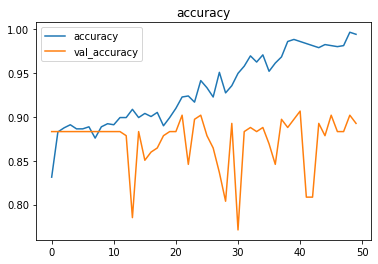

In [ ]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.title('accuracy')
# plt.plot(history['binary_accuracy'])
# plt.plot(history['val_binary_accuracy'])
# plt.legend(['binary_accuracy', 'val_binary_accuracy'])
# plt.title('binary_accuracy')

Text(0.5, 1.0, 'loss')

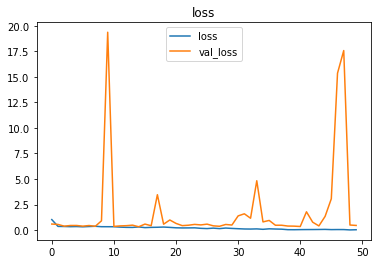

In [ ]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title('loss')

### Metrics

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

y_true = y_test
prediction = model.predict(X_test)
threshold = 0.5

y_pred = np.where(prediction > threshold, 1, 0)

print(y_true.shape, y_pred.shape)

(214, 2) (214, 2)


In [ ]:
# classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94       189
           1       0.56      0.36      0.44        25

   micro avg       0.89      0.89      0.89       214
   macro avg       0.74      0.66      0.69       214
weighted avg       0.88      0.89      0.88       214
 samples avg       0.89      0.89      0.89       214



In [ ]:
# Confusion matrix:
#   row: Ground truth
#   column: predict
print(confusion_matrix(y_true, y_pred))

In [ ]:
from sklearn.metrics import roc_curve, auc

In [ ]:

y_true = np.argmax(y_true, axis=-1)
prediction = prediction[:, 1]

y_true.shape, prediction.shape

((214,), (214,))

In [ ]:

fp_rate, tp_rate, threshold = roc_curve(y_true, prediction, drop_intermediate=False)
print('False Positive rate: ', fp_rate)
print('True Positive rate: ', tp_rate)
print('Threshold: ', threshold)

False Positive rate:  [0.         0.         0.         0.         0.         0.
 0.         0.00529101 0.00529101 0.01058201 0.01587302 0.01587302
 0.02116402 0.02645503 0.03174603 0.03703704 0.03703704 0.04232804
 0.04761905 0.04761905 0.05291005 0.05291005 0.05820106 0.06349206
 0.06349206 0.06349206 0.06878307 0.07407407 0.07936508 0.08465608
 0.08465608 0.08994709 0.08994709 0.0952381  0.0952381  0.1005291
 0.10582011 0.11111111 0.11640212 0.12169312 0.12698413 0.12698413
 0.13227513 0.13756614 0.14285714 0.14814815 0.15343915 0.15873016
 0.16402116 0.16931217 0.17460317 0.17989418 0.18518519 0.19047619
 0.1957672  0.2010582  0.2010582  0.2010582  0.2010582  0.20634921
 0.21164021 0.21693122 0.22222222 0.22751323 0.23280423 0.23809524
 0.24338624 0.24867725 0.25396825 0.25396825 0.25925926 0.26455026
 0.26984127 0.27513228 0.28042328 0.28571429 0.29100529 0.2962963
 0.3015873  0.30687831 0.31216931 0.31746032 0.32275132 0.32804233
 0.33333333 0.33862434 0.34391534 0.34920635 0.354

In [ ]:
len(fp_rate)

215

In [ ]:
# AUC 
auc_score = auc(fp_rate, tp_rate)
print(f'auc: {auc_score}')

auc: 0.8681481481481482


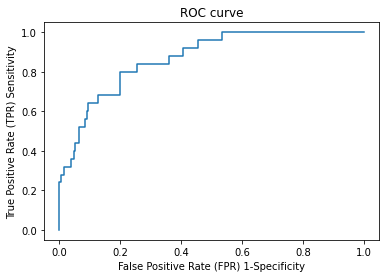

In [ ]:
# ROC curve
plt.xlabel('False Positive Rate (FPR) 1-Specificity')
plt.ylabel('True Positive Rate (TPR) Sensitivity')
plt.plot(fp_rate, tp_rate)
plt.title('ROC curve')
plt.show()

#### Save model

In [ ]:
# 1. save whole model and weights
model.save('my_model.h5')

model2 = models.load_model('my_model.h5')
# mode1 = model2

In [ ]:
# 2. save and load weights only
model.save_weights('my_model_weights.h5')

# Rebuild model before load weights !
model2 = build_model()
model2.load_weights('my_model_weights.h5')

# model = model2

# binary classification 
0: Free
1 : defect 1+2+3

# 多分類
0: free
1: defect 1
2: defect 2

0: free
1: defect 1 + defect 2
2: defect 3 + 4

0: defect 1 + 2
1: defect 3 + 4